# Synexpression groups identification

ID: 

Name: Iris Milligan

Last modified: 31.01.2021

## Required libraries

In [55]:
import pandas as pd
import scipy
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex, colorConverter
import numpy as np
from scipy import stats
from scipy.signal import find_peaks
from collections import defaultdict
import seaborn as sns
import statsmodels.api as sm
import os
import scipy.cluster.hierarchy as sch
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


## Data import

In [56]:
# Import external data
# convert data type

    
# import data for analysis
data = pd.read_table("testgenes.csv",delimiter = ',')
# set index
data.index = data['gene'] 
data = data.drop(['ENSEMBL','gene','name'], axis=1)

# subset gene
# Drop section 45-96
data = data[data.columns[0:44]]


## Data Preperation for Pearson Correlation


In [57]:
# Remove Null Records
data=data.dropna()

# Transpose Matrix for processing
dataT=data.T

# Print output to confirm data format
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('transposed_output.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
dataT.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

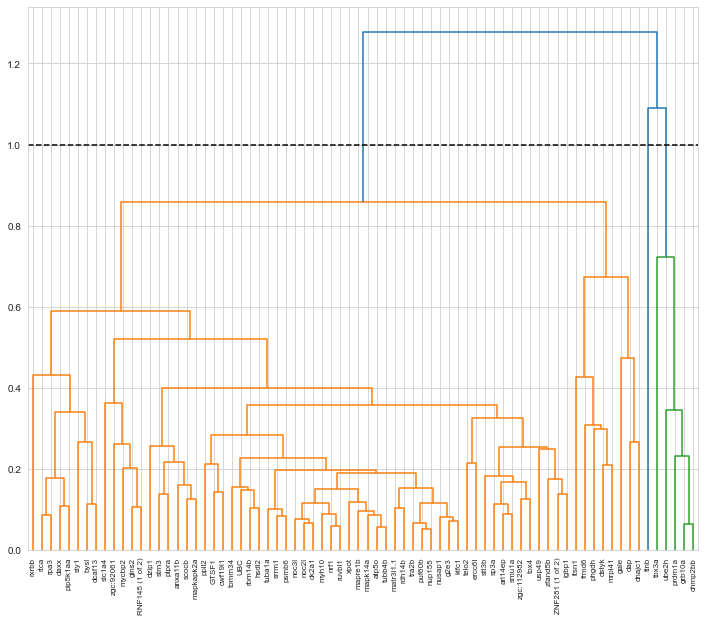

In [58]:
# Define the Pearson Correlation
# pearcorr = dataT.corr('pearson')
from scipy.cluster.hierarchy import cut_tree
pearcorr = pdist(data,'correlation')


# Plot Dendrogram
# Setup Plot Size
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
import seaborn as sns
sns.set_style("whitegrid")

lnk=linkage(pearcorr, metric='correlation', method='complete')

link_4 = cut_tree(lnk,n_clusters = 4)

pd.crosstab(index=data.index, columns = link_4.T[0],rownames = ['Sec'], colnames = ['gne'])
fig, ax = plt.subplots(1,1,figsize = (12,10))

#dn = dendrogram(lnk, labels=list(data.columns), leaf_font_size = 8, show_leaf_counts = True)
dn = dendrogram(lnk, labels=list(dataT.columns), leaf_font_size = 8, show_leaf_counts = True)
plt.axhline(y=1.0, c='k', ls='dashed')
plt.show()

In [9]:
# Function to plot sections of the Dedrogram
def plot_tree(P, pos=None):
    plt.clf()
    icoord = scipy.array(P['icoord'])
    dcoord = scipy.array(P['dcoord'])
    color_list = scipy.array(P['color_list'])
    xmin, xmax = icoord.min(), icoord.max()
    ymin, ymax = dcoord.min(), dcoord.max()
    if pos:
        icoord = icoord[pos]
        dcoord = dcoord[pos]
        color_list = color_list[pos]
    for xs, ys, color in zip(icoord, dcoord, color_list):
        plt.plot(xs, ys, color)
    plt.xlim(xmin-10, xmax + 0.1*abs(xmax))
    plt.ylim(ymin, ymax + 0.1*abs(ymax))
    plt.show()

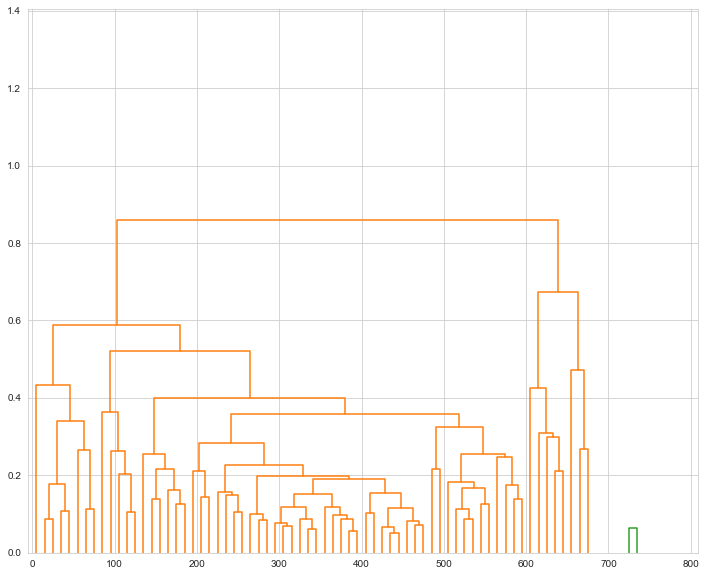

In [379]:
# Plot sub-section
dmin = 0.0
dmax = 0.6
pos = scipy.all((lnk[:,2] >= dmin, lnk[:,2] <= dmax), axis=0).nonzero()

plot_tree( dn, pos )

<Figure size 1152x432 with 0 Axes>

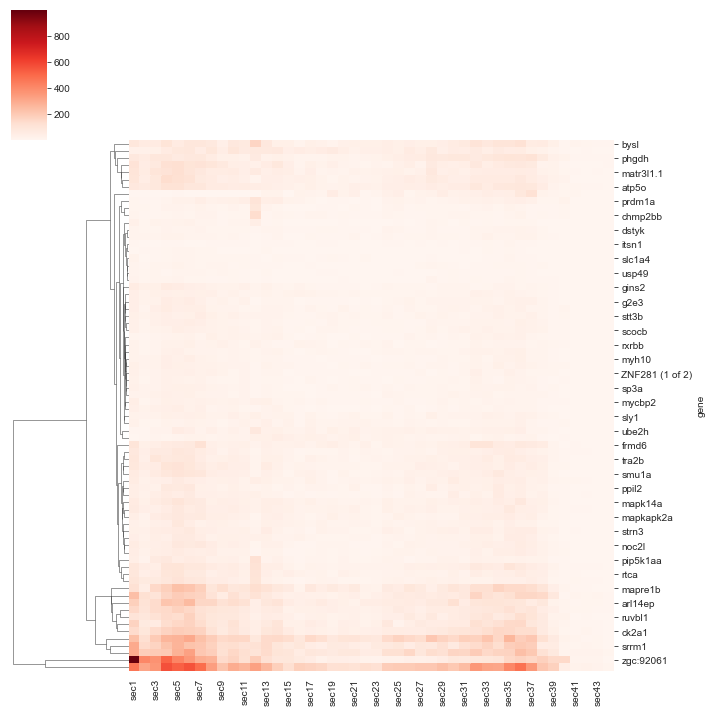

In [62]:
plt.figure(figsize=(16, 6))
p1 = sns.clustermap(data,cmap="Reds",col_cluster=False)

In [10]:
# build class to control clusters
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

# set tick size for readability
def get_clust_graph(df, numclust, transpose=False, dataname=None, save=False, xticksize=8):
    if transpose==True:
        aml=df.transpose()
        xl="x-axis"
    else:
        aml=df
        xl="y-axis"
    data_dist = pdist(aml.transpose(),'correlation') # computing the distance
    data_link = linkage(data_dist,  metric='correlation', method='complete')#method="complete") # computing the linkage
    B=dendrogram(data_link,labels=list(aml.columns),p=numclust, truncate_mode="lastp",get_leaves=True, count_sort='ascending', show_contracted=True)
    #myInd = [i for i, c in zip(B['ivl'], B['color_list']) if c=='g']
    get_cluster_classes(B)
    ax=plt.gca()
    ax.tick_params(axis='x', which='major', labelsize=xticksize)
    ax.tick_params(axis='y', which='major', labelsize=15)
    plt.xlabel(xl)
    #plt.set_size_inches(33.1, 23.4)
    plt.ylabel('Distance')
    plt.suptitle(xl+" clustering for "+dataname, fontweight='bold', fontsize=16);
    if save:
        plt.savefig(str(df.index.name)+str(numclust)+"tr_"+str(transpose)+"dn_"+str(dataname)+save+'.png')
    else:
        print("Not saving")
    return get_cluster_classes(B)

# how to show values in no clusters
def give_cluster_assigns(df, numclust, tranpose=True):
    if transpose==True:
        data_dist = pdist(df.transpose(),'correlation')
        data_link = linkage(data_dist,  metric='correlation', method='complete')
        cluster_assigns=pd.Series(sch.fcluster(data_link, numclust, criterion='maxclust', monocrit=None), index=df.columns)
    else:
        data_dist = pdist(df,'correlation')
        data_link = linkage(data_dist,  metric='correlation', method='complete')
        cluster_assigns=pd.Series(sch.fcluster(data_link, numclust, criterion='maxclust', monocrit=None), index=df.index)
    for i in arange(1,numclust+1):
        print("Cluster ",str(i),": ( N =",len(cluster_assigns[cluster_assigns==i].index),")", ", ".join(list(cluster_assigns[cluster_assigns==i].index)))

Not saving


C1,"['grb10a', 'chmp2bb', 'prdm1a', 'ube2h', 'tbx3a']"
C0,['ttnb']
C2,"['dap', 'dnajc1', 'gale', 'dstyk', 'mrpl41', 'phgdh', 'frmd6', 'itsn1', 'bysl', 'dcaf13', 'sly1', 'rtca', 'rpa3', 'daxx', 'pip5k1aa', 'rxrbb', 'gins2', 'RNF145 (1 of 2)', 'mycbp2', 'zgc:92061', 'slc1a4', 'strn3', 'ptpra', 'scocb', 'mapkapk2a', 'anxa11b', 'dzip1', 'telo2', 'ercc6l', 'ZNF281 (1 of 2)', 'igbp1', 'zfand5b', 'usp49', 'zgc:112982', 'tox4', 'arl14ep', 'smu1a', 'sp3a', 'stt3b', 'GTSF1', 'cwf19l1', 'ppil2', 'rbm14b', 'hsdl2', 'UBC', 'tomm34', 'srrm1', 'psmb6', 'tuba1a', 'matr3l1.1', 'rdh14b', 'puf60b', 'nup155', 'tra2b', 'g2e3', 'kifc1', 'nusap1', 'atp5o', 'tubb4b', 'mapk14a', 'mapre1b', 'xpot', 'noc2l', 'ck2a1', 'noc3l', 'nrf1', 'ruvbl1', 'myh10']"


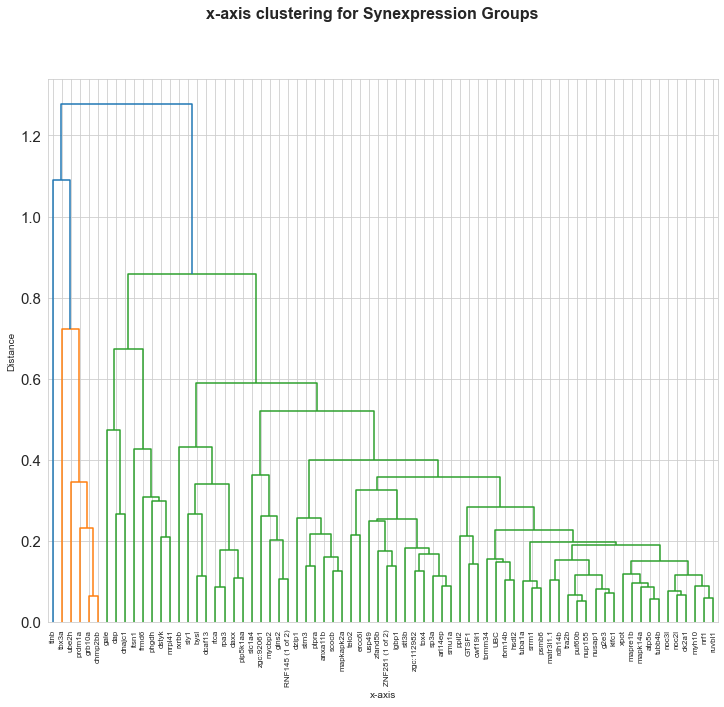

In [10]:
# Call plot
get_clust_graph(data, 3837, transpose=True,dataname="Synexpression Groups")

In [11]:
dataT.head()

gene,nrf1,ube2h,dap,itsn1,myh10,zgc:92061,usp49,matr3l1.1,slc1a4,ttnb,ZNF281 (1 of 2),daxx,sly1,telo2,dstyk,mapk14a,GTSF1,dzip1,bysl,arl14ep,mycbp2,puf60b,srrm1,rbm14b,g2e3,sp3a,tomm34,kifc1,strn3,noc2l,ptpra,nup155,atp5o,zgc:112982,phgdh,tuba1a,stt3b,dnajc1,rxrbb,grb10a,ppil2,tox4,ck2a1,cwf19l1,tra2b,igbp1,chmp2bb,rtca,tbx3a,scocb,psmb6,mrpl41,dcaf13,zfand5b,xpot,gins2,frmd6,tubb4b,UBC,gale,nusap1,prdm1a,rdh14b,ercc6l,noc3l,hsdl2,smu1a,mapkapk2a,ruvbl1,RNF145 (1 of 2),rpa3,pip5k1aa,anxa11b,mapre1b
sec1,30.53,5.96,28.30,6.70,22.34,999.26,12.66,96.05,20.10,2.23,29.04,30.53,21.59,17.87,14.89,60.31,55.10,3.72,84.14,182.43,43.19,148.92,302.31,168.28,39.46,29.04,20.85,90.84,35.00,57.33,17.13,74.46,74.46,39.46,74.46,236.79,34.25,11.91,21.59,11.91,43.93,33.51,137.75,46.91,82.65,23.83,14.15,84.89,2.23,28.30,303.06,13.40,84.14,40.95,40.95,57.33,95.31,461.66,233.06,26.06,79.67,9.68,109.46,13.40,50.63,63.29,59.57,43.93,103.50,36.49,96.05,44.68,28.30,119.88
sec2,15.09,6.35,30.64,1.99,16.99,406.53,8.74,57.96,3.57,1.19,14.92,10.33,15.89,9.53,10.33,34.07,25.16,5.56,62.24,109.88,11.91,102.81,143.20,68.91,20.09,16.60,11.91,49.14,28.91,33.22,16.51,40.65,64.20,13.90,61.53,125.08,20.65,7.15,11.91,9.13,31.35,16.68,86.16,25.02,38.10,11.52,5.96,42.16,5.08,13.33,190.02,13.96,52.79,23.18,24.77,34.53,35.15,318.07,128.37,9.93,48.71,6.35,53.48,7.86,24.23,41.82,37.93,16.11,85.71,20.14,69.96,17.68,19.77,49.68
sec3,29.85,17.78,32.02,3.76,21.11,377.52,12.44,94.85,5.06,1.01,19.66,21.25,22.85,15.62,9.32,56.60,38.02,4.26,61.73,138.43,17.06,139.22,167.55,62.24,25.30,19.30,14.89,79.38,50.82,40.27,24.22,64.55,78.58,39.68,82.48,103.51,29.64,15.04,15.69,6.72,24.07,23.06,139.08,44.82,90.58,17.06,7.52,51.75,14.89,22.70,196.76,13.52,43.30,33.61,45.62,33.68,46.19,361.07,197.57,11.13,54.14,4.77,73.96,12.07,45.76,37.01,62.53,54.36,114.21,30.22,68.60,63.41,38.53,150.67
sec4,39.27,17.70,61.94,6.91,40.36,514.31,7.74,106.44,8.85,3.59,28.47,19.07,34.28,15.76,19.63,72.15,40.65,11.33,97.89,217.86,33.45,145.43,224.50,135.21,53.35,29.58,29.03,134.33,53.91,50.31,36.22,64.97,110.03,55.01,82.95,162.84,43.13,16.59,26.54,17.14,70.50,42.58,171.41,59.16,71.33,29.86,11.34,92.91,11.06,23.78,205.43,20.18,95.65,37.33,38.98,61.94,61.65,567.79,269.24,20.18,98.70,14.66,118.87,13.27,48.92,54.19,82.39,65.25,141.55,37.33,85.16,74.92,40.09,180.78
sec5,40.21,54.70,79.19,6.76,27.84,416.44,11.92,125.82,12.13,4.25,28.98,21.65,28.55,16.28,12.95,94.17,63.34,12.50,62.02,204.46,30.83,174.51,272.48,152.78,45.62,32.66,39.19,121.83,59.47,75.55,28.29,84.45,110.60,41.81,62.92,192.82,29.31,21.32,26.47,17.77,66.92,33.00,190.03,47.55,82.04,25.43,15.58,100.47,15.81,46.87,277.48,21.65,100.51,34.81,62.77,52.80,62.75,523.93,274.06,19.38,108.84,25.19,126.21,19.83,58.79,77.12,103.84,77.16,134.21,45.23,107.92,50.38,80.58,231.80


In [12]:
# MAX GENE
max(dataT) 


'zgc:92061'

In [13]:
# MIN GENE
min(dataT)

'GTSF1'

In [87]:
#DEFINE Quantile
import pandas as pd 
df = dataT
quant = df.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
quant


gene,nrf1,ube2h,dap,itsn1,myh10,zgc:92061,usp49,matr3l1.1,slc1a4,ttnb,ZNF281 (1 of 2),daxx,sly1,telo2,dstyk,mapk14a,GTSF1,dzip1,bysl,arl14ep,mycbp2,puf60b,srrm1,rbm14b,g2e3,sp3a,tomm34,kifc1,strn3,noc2l,ptpra,nup155,atp5o,zgc:112982,phgdh,tuba1a,stt3b,dnajc1,rxrbb,grb10a,ppil2,tox4,ck2a1,cwf19l1,tra2b,igbp1,chmp2bb,rtca,tbx3a,scocb,psmb6,mrpl41,dcaf13,zfand5b,xpot,gins2,frmd6,tubb4b,UBC,gale,nusap1,prdm1a,rdh14b,ercc6l,noc3l,hsdl2,smu1a,mapkapk2a,ruvbl1,RNF145 (1 of 2),rpa3,pip5k1aa,anxa11b,mapre1b
0.1,5.028,3.804,7.220,0.442,2.581,20.076,1.070,10.125,1.036,1.325,1.841,1.031,2.974,1.016,1.585,8.943,8.382,0.661,12.917,15.613,4.340,17.943,22.764,15.127,1.849,1.940,2.722,11.131,5.067,5.077,2.365,5.143,12.105,5.457,12.458,17.083,7.674,1.671,1.991,2.053,4.808,3.625,16.542,4.556,6.922,2.488,5.027,6.497,3.588,3.527,28.089,2.248,7.825,2.340,4.842,3.830,5.919,65.944,34.941,6.552,9.564,2.260,7.492,1.016,5.862,6.626,4.334,7.540,17.492,1.469,8.102,4.419,4.345,15.059
0.2,6.440,13.256,29.704,1.580,5.500,27.728,1.592,19.586,1.910,2.326,4.560,2.540,8.820,1.522,4.768,17.410,15.310,0.950,31.146,39.550,5.460,30.828,51.314,29.988,4.322,5.472,5.936,19.052,11.714,7.952,5.700,10.848,21.252,7.840,20.000,30.400,9.098,4.696,6.342,4.340,9.220,6.622,34.622,6.424,12.822,4.502,6.042,15.996,8.208,6.636,69.084,4.118,17.966,8.960,10.506,5.414,18.964,125.988,81.292,8.828,13.296,5.250,17.170,1.560,8.544,18.960,10.930,12.498,23.434,3.058,10.494,8.840,12.450,41.096
0.3,10.170,17.649,36.478,2.380,6.111,39.943,2.229,23.695,2.694,3.761,6.331,3.598,13.570,2.615,6.705,22.411,19.252,1.230,33.132,49.261,7.387,36.545,65.878,39.916,6.721,7.746,9.796,30.263,17.744,12.316,7.657,14.125,33.185,10.535,25.548,39.820,11.338,6.871,9.141,5.999,14.238,8.624,43.494,10.820,16.099,6.040,7.237,18.647,13.931,9.082,82.481,6.297,19.613,10.734,14.419,7.827,24.076,176.141,122.425,11.283,15.735,9.125,21.656,2.999,12.833,21.928,16.635,15.412,31.021,4.699,15.813,13.009,16.145,53.487
0.4,11.574,20.136,43.430,3.576,7.536,70.998,3.802,31.776,3.574,8.568,7.752,4.032,15.984,3.854,7.642,28.090,23.530,1.594,35.158,57.774,10.758,47.420,72.388,52.636,12.344,9.662,11.438,38.572,21.174,16.106,9.410,17.140,42.146,13.900,32.914,57.060,13.188,9.414,10.048,7.948,17.318,11.444,56.320,15.312,24.110,7.916,7.974,23.706,15.226,11.652,104.624,7.776,32.524,13.300,17.364,10.432,26.896,197.576,136.742,12.940,22.094,13.252,34.650,4.116,15.604,26.982,25.410,18.468,40.626,6.000,21.900,15.324,19.554,69.206
0.5,14.520,23.270,47.180,4.210,10.025,86.405,4.250,41.150,4.445,13.875,10.745,5.910,17.880,4.450,9.200,32.995,26.740,2.105,42.420,66.465,13.180,57.265,90.030,61.215,14.175,12.290,13.270,41.940,26.160,22.060,11.835,20.415,47.110,15.440,48.145,64.510,17.595,11.520,11.940,9.320,21.930,12.735,64.275,19.465,31.365,9.780,9.120,31.450,18.120,15.665,123.085,9.940,38.620,14.720,21.595,12.370,32.915,211.940,147.290,15.145,31.005,16.975,42.825,6.230,20.175,32.250,29.770,23.820,54.995,8.940,24.985,19.065,22.425,77.530
0.6,17.318,26.178,51.768,4.648,12.626,121.658,6.140,48.294,6.758,21.844,13.372,8.624,21.504,5.488,10.714,34.576,32.700,3.232,61.640,88.408,14.694,64.570,120.122,68.374,16.808,14.060,14.828,47.800,30.718,29.620,13.172,27.766,52.862,16.818,62.642,76.652,19.096,13.966,14.718,10.868,24.934,14.848,88.968,25.580,34.888,11.150,10.754,39.226,19.876,20.560,147.886,12.062,46.204,19.238,24.898,14.232,35.608,255.776,154.260,16.258,36.244,23.294,45.508,7.158,23.302,36.114,36.714,33.340,64.844,12.598,29.884,23.290,25.990,92.850
0.7,19.811,28.535,61.961,5.374,15.280,155.696,7.704,54.186,8.054,24.180,14.932,10.371,22.494,7.146,13.280,42.908,34.965,4.125,70.509,99.893,17.063,83.644,137.622,85.835,20.495,16.604,17.479,58.027,36.226,34.160,16.492,35.024,59.118,19.537,71.760,111.291,20.703,16.924,16.744,12.034,30.918,17.870,105.483,32.137,38.583,13.016,11.777,43.009,23.052,22.735,162.033,13.531,52.792,23.250,31.612,16.757,44.624,318.346,176.162,19.597,43.022,25.325,65.149,9.096,26.148,39.793,38.842,39.003,81.450,13.475,37.778,25.972,27.

In [67]:
#Label Gene Section Q1-Q4 base on Quintile value
def LabelFunc(xvalue,icolumn):

    if(xvalue<=quant.iloc[0][icolumn]):
        retvalue = "1"
    else:
        if(xvalue<=quant.iloc[1][icolumn]):
            retvalue = "2"
        else:
            if(xvalue<=quant.iloc[2][icolumn]):
                retvalue = "3" 
            else: retvalue = "4"
    return retvalue

In [88]:
#Label Gene Section 1-10 based on Quintile value
def LabelFunc2(xvalue,icolumn):
    if(xvalue<=quant.iloc[0][icolumn]): retvalue = "1"
    elif(xvalue<=quant.iloc[1][icolumn]): retvalue = "2"
    elif(xvalue<=quant.iloc[2][icolumn]): retvalue = "3" 
    elif(xvalue<=quant.iloc[3][icolumn]): retvalue = "4"
    elif(xvalue<=quant.iloc[4][icolumn]): retvalue = "5" 
    elif(xvalue<=quant.iloc[5][icolumn]): retvalue = "6"
    elif(xvalue<=quant.iloc[6][icolumn]): retvalue = "7" 
    elif(xvalue<=quant.iloc[7][icolumn]): retvalue = "8"
    elif(xvalue<=quant.iloc[8][icolumn]): retvalue = "9" 
    else: retvalue = "10"
    return retvalue 

In [89]:
# Process Gene Data against Quantile
import xlsxwriter
Cols = len(dataT.columns)
Rows = len(dataT)
df=dataT
# Create new Excel file below here
workbook   = xlsxwriter.Workbook('Quantiles.xlsx')
worksheet1 = workbook.add_worksheet()

# Add a header format.
header_format = workbook.add_format({
    'bold': True,
    'text_wrap': True,
    'valign': 'top',
    'fg_color': '#D7E4BC',
    'border': 1})

# Write the column headers with the defined format.
# but first set label for later indexing
worksheet1.write(0,0,"gene")
for col_num, value in enumerate(dataT.columns.values):
    worksheet1.write(0, col_num + 1, value, header_format)

# Write the row headers with the defined format.
for row_num, value in enumerate(dataT.index):
    worksheet1.write(row_num + 1, 0, value, header_format)
# Logic

p=0
q=0

while q < Cols:
    p=0
    while p < Rows:
        z = dataT.iloc[p][q]
        ret1 =LabelFunc2(z,q)
        # Instead of print write to excel cell 
        worksheet1.write(p+1, q+1, ret1)  
        p=p+1
    q=q+1
workbook.close()

<Figure size 1152x432 with 0 Axes>

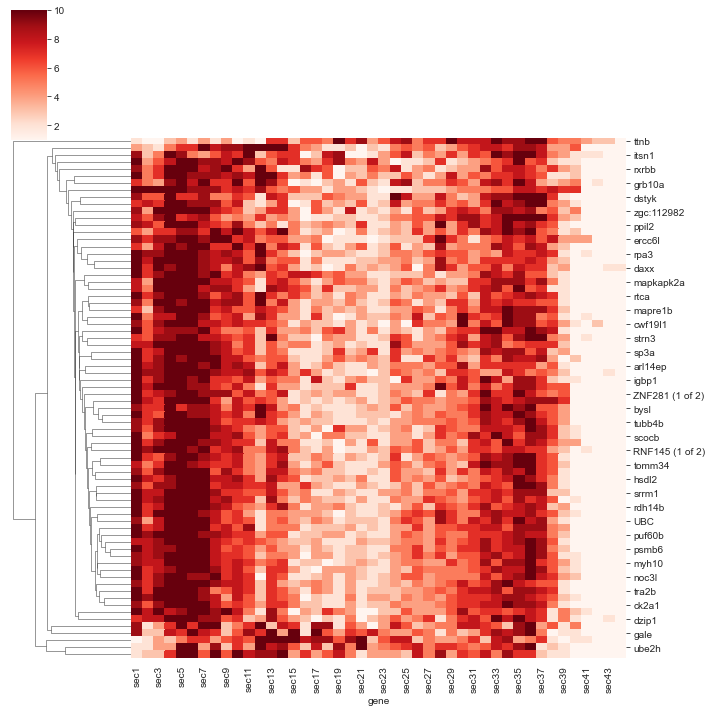

<Figure size 1152x432 with 0 Axes>

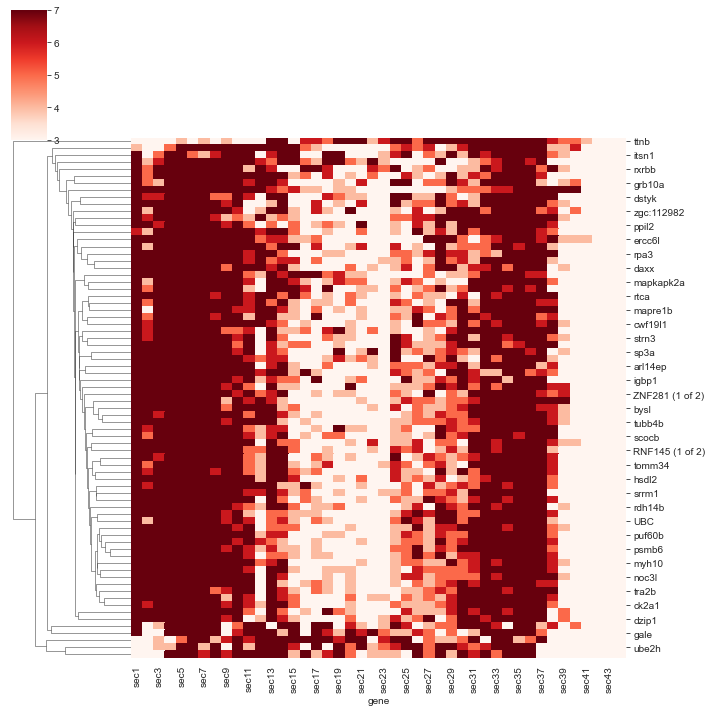

In [91]:
# HEAT MAP based on Quantiles arranged above
# Open and Read Quantiles.xlsx
# Import external data
# convert data type

    
# import data for analysis
qdata = pd.read_excel("Quantiles.xlsx",sheet_name='Sheet1')

# set index to and axis to gene
qdata.index = qdata['gene'] 
qdata = qdata.drop('gene', axis=1)

#Transpose qdata
qdataT = qdata.T

# Build Heatmap
plt.figure(figsize=(16, 6))
p1 = sns.clustermap(qdataT,cmap="Reds",col_cluster=False)


# exclude Q1 and Q4 data 
plt.figure(figsize=(16, 6))
p1 = sns.clustermap(qdataT,cmap="Reds", vmin=3, vmax=7, col_cluster=False)


In [64]:
sns.clustermap??

Signature:
sns.clustermap(
    data,
    pivot_kws=None,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=None,
    figsize=(10, 10),
    cbar_kws=None,
    row_cluster=True,
    col_cluster=True,
    row_linkage=None,
    col_linkage=None,
    row_colors=None,
    col_colors=None,
    mask=None,
    dendrogram_ratio=0.2,
    colors_ratio=0.03,
    cbar_pos=(0.02, 0.8, 0.05, 0.18),
    tree_kws=None,
    **kwargs,
)
Source:   
def clustermap(data, pivot_kws=None, method='average', metric='euclidean',
               z_score=None, standard_scale=None, figsize=(10, 10),
               cbar_kws=None, row_cluster=True, col_cluster=True,
               row_linkage=None, col_linkage=None,
               row_colors=None, col_colors=None, mask=None,
               dendrogram_ratio=.2, colors_ratio=0.03,
               cbar_pos=(.02, .8, .05, .18), tree_kws=None,
               **kwargs):
    """Plot a matrix dataset as a hierarchically-clustered heatmap.

    P

In [ ]:
# To Be investigated later Didn't work, why?
if dataT <= df.quantile([.25, .50, .75, 1.00]): 
    print("q1", "q2", "q3", "q4")


In [ ]:

# Didn't work, why?
# Python Program illustrating 
# numpy.percentile() method 
   
import numpy as np
   
# 1D array 
arr = [dataT]
print("arr : ", arr) 
print("50th percentile of arr : ", 
       np.percentile(arr, 50))
print("25th percentile of arr : ",
       np.percentile(arr, 25))
print("75th percentile of arr : ",
       np.percentile(arr, 75))

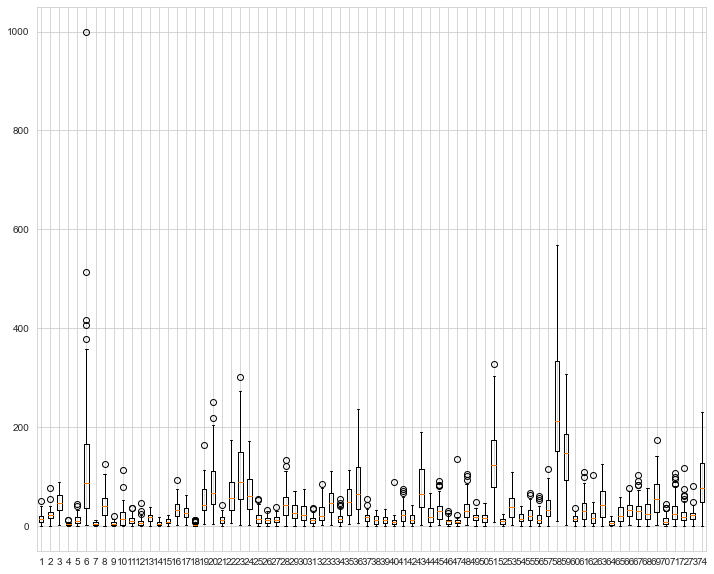

In [21]:
import matplotlib.pyplot as plt
# basic plot
plt.boxplot(data)
plt.show()


Text(0, 0.5, 'Expression level')

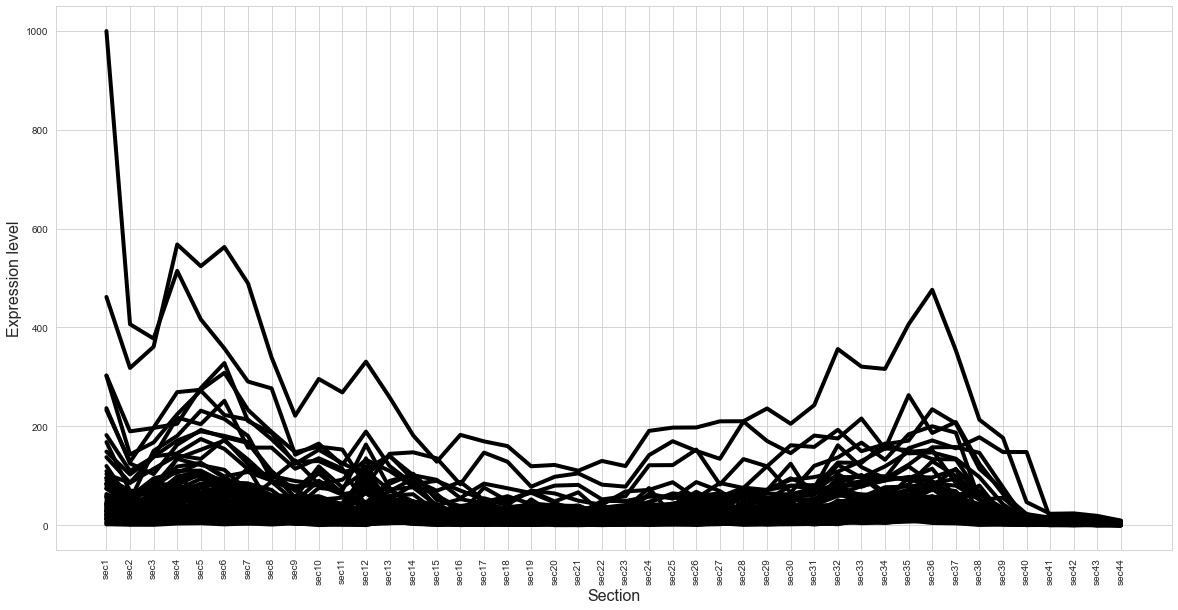

In [20]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.plot(dataT,color='black',linewidth=4.0) # change mean to median if needed
plt.xlabel('Section',fontsize=16)
plt.ylabel('Expression level',fontsize=16)

In [19]:
df = dataT
df.quantile([.25, .5,.75, 1.0])
df1 = df.quantile([.25,.5,.75, 1.0])
F = DataFrame.groupby(df.quantile(.25),1)
print(F)

NameError: name 'DataFrame' is not defined

In [ ]:

F = DataFrame.groupby('sec')['Gene'].quantile([0.2, 0.5, 0.75])
df.columns = ['1st quartile','2nd quartile','3rd quartile']


In [ ]:
print(len(dataT.columns))

len(dataT)